In [50]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
from time import time
from glob import glob 
from skimage.feature import hog 
from skimage.io import imread
from skimage import exposure
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import cv2

from moviepy.editor import VideoFileClip
from collections import deque

In [2]:
vehicles = glob("data/vehicles/*.png")
non_vehicles = glob("data/non-vehicles/*.png")

print("Count of vehicles: ",len(vehicles))
print("Count of non vehicles: ",len(non_vehicles))

Count of vehicles:  8792
Count of non vehicles:  8968


In [3]:
def color_hist(img):
    # Take histograms in R, G, and B
    rhist = np.histogram(img[:,:,0])
    ghist = np.histogram(img[:,:,1])
    bhist = np.histogram(img[:,:,2])
    
    # Concatenate
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    return hist_features

In [34]:
def hog_hist(img):
    #img_grayscale = rgb2ycbcr(img)
    hog_hist, hog_image = hog(img, visualize=True, orientations=9,pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=False, feature_vector=False)
    return hog_hist

In [35]:
def bin_spatial(img, size=(32,32)):
    color1 = cv2.resize(img[:,:,0], size).ravel() 
    color2 = cv2.resize(img[:,:,1], size).ravel() 
    color3 = cv2.resize(img[:,:,2], size).ravel() 
    return np.hstack((color1, color2, color3))

In [36]:
def extract_features(imgs):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = imread(file)
        feature_image = np.copy(image)      
        spatial_features = bin_spatial(feature_image)
        file_features.append(spatial_features)
        
        hist_features = color_hist(feature_image)
        file_features.append(hist_features)
        
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(hog_hist(feature_image[:,:,channel]))
        hog_features = np.ravel(hog_features)
        file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [7]:
t = time()
car_features = extract_features(vehicles)    

notcar_features = extract_features(non_vehicles)    

t2 = time()
print(round((t2-t), 2), 'seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print(round((time()-t2), 2), 'seconds to store features...')

print('Training data storage done')

292.59 seconds to compute features...
2.16 seconds to store features...
Training data storage done


In [8]:
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC
parameters = {'C':[0.01, 0.001, 0.0001]}
svr =  LinearSVC()
svc = GridSearchCV(svr, parameters)

# Check the training time for the SVC
t = time()

svc.fit(X_train, y_train)

t2 = time()
print(round((t2-t), 2), 'seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print('Best params:', svc.best_params_)


Feature vector length: 8394
85.04 seconds to train SVC...
Test Accuracy of SVC =  0.9837
Best params: {'C': 0.0001}


In [37]:
def find_cars(img, scale, ystart, ystop, svc, X_scaler):
    img_boxes = []
    t = time()
    count = 0
    draw_img = np.copy(img)
    # Uncomment when img is jpg & training data is png
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (int(imshape[1]/scale), int(imshape[0]/scale)))  
        
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // 8) - 1
    nyblocks = (ch1.shape[0] // 8) - 1
    nfeat_per_block = 9 * 8**2
    window = 64
    nblocks_per_window = (window // 8) - 1
    cells_per_step = 1 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = hog_hist(ch1)
    hog2 = hog_hist(ch2)
    hog3 = hog_hist(ch3)
    
    # This will give you a series of HOG window extracts
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            #Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * 8
            ytop = ypos * 8

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                count += 1
                xbox_left = int(xleft*scale)
                ytop_draw = int(ytop*scale)
                win_draw = int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    #print(time.time()-t, 'seconds to run, total windows = ', count)
    
    return draw_img, img_boxes, count

In [38]:
def add_heat(heatmap, windows):
    for window in windows:
        heatmap[window[0][1]:window[1][1],window[0][0]:window[1][0]] += 1
        #heatmap = 255 * heatmap / np.max(heatmap)
    return heatmap

In [39]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [40]:
from scipy.ndimage import label

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [41]:
def show_image(image1, image2, count):
    # Text Display
    text1 = 'Total windows found: ' + str(count)
    org1 = (50,50)

    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.95
    color = (255,255,255)
    thickness = 2
    cv2.putText(image1, text1, org1, font, scale, color, thickness)
    """
    import cv2
    s_img = cv2.imread("smaller_image.png")
    l_img = cv2.imread("larger_image.jpg")
    x_offset=y_offset=50
    l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
    """
    
    return image1

In [42]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [43]:
def img_pipeline(img_src, threshold, svc, X_scaler):
    img = imread(img_src)
    
    # Using a scale = 1., equivalent to a window size 64x64, within the range of 400 < y < 480
    draw_img1, img_boxes1, count1 = find_cars(img, 1., 400, 480, svc, X_scaler)
    # Using a scale = 1.5, equivalent to a window size 96x96, within the range of 400 < y < 528
    draw_img2, img_boxes2, count2 = find_cars(img, 1.5, 400, 528, svc, X_scaler)
    # Using a scale = 2., equivalent to a window size 128x128, within the range of 400 < y < 656
    draw_img3, img_boxes3, count3 = find_cars(img, 2., 400, 656, svc, X_scaler)
    
    # Consolidate results
    draw_img = cv2.add(draw_img1, draw_img2, draw_img3)
    img_boxes = img_boxes1 + img_boxes2 + img_boxes3
    count = count1 + count2 + count3
    
    # Apply heatmap
    heatmap = np.zeros_like(img[:,:,0])
    heatmap1 = add_heat(heatmap, img_boxes)
    heatmap2 = apply_threshold(heatmap1, threshold)
    
    # Label areas and draw boxes
    labels = label(heatmap2)
    heat = draw_labeled_bboxes(np.copy(heatmap2), labels)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    draw_img = show_image(draw_img, heatmap2, count)
    
    return img, draw_img

In [44]:
example_images = glob('test_images/test*')
out_images = []
out_titles = []
threshold = 3

for img_src in example_images:
    
    source_img, draw_img = img_pipeline(img_src, threshold, svc, X_scaler)
    
    out_images.append(source_img)
    out_images.append(draw_img)
    out_titles.append(img_src)
    out_titles.append('final image')

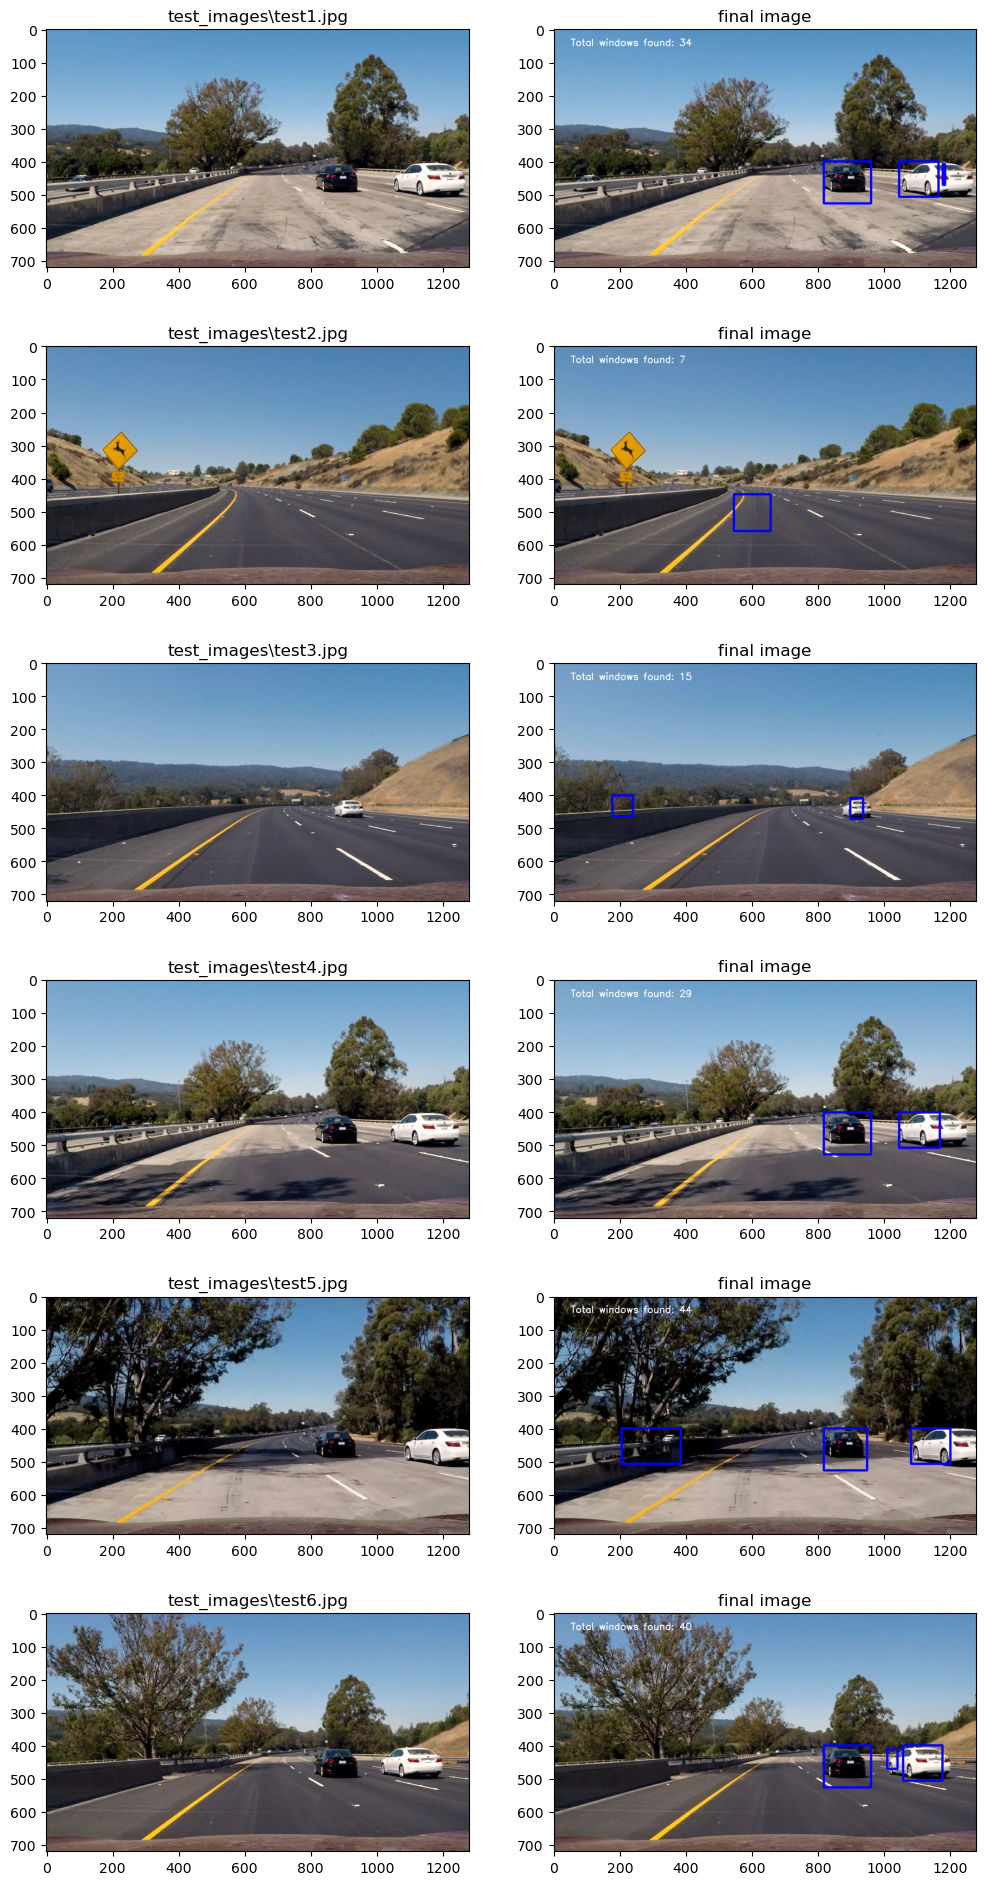

In [45]:
fig = plt.figure(figsize=(12,24))
visualize(fig, 6, 2, out_images, out_titles)

In [46]:
class Heatmaps():
    def _init_(self):
        self.maxlen = 0
        self.heatmaps = []
        
    def average_heat(self, heatmap, maxlen):
        self.maxlen = maxlen
        self.heatmaps.append(heatmap)
        """
        if len(self.heatmaps) == self.maxlen:
            return sum(self.heatmaps)/self.maxlen
        else:
            return sum(self.heatmaps)/len(self.heatmaps)
        """
        return sum(self.heatmaps)

In [19]:
def pipeline(img, svc, X_scaler):

    # Using a scale = 1., equivalent to a window size 64x64, within the range of 400 < y < 480
    draw_img1, img_boxes1, count1 = find_cars(img, 1., 400, 480, svc, X_scaler)
    # Using a scale = 1.5, equivalent to a window size 96x96, within the range of 400 < y < 528
    draw_img2, img_boxes2, count2 = find_cars(img, 1.5, 400, 528, svc, X_scaler)
    # Using a scale = 2., equivalent to a window size 128x128, within the range of 400 < y < 656
    draw_img3, img_boxes3, count3 = find_cars(img, 2., 400, 656, svc, X_scaler)
    
    # Consolidate results
    draw_img = cv2.add(draw_img1, draw_img2, draw_img3)
    img_boxes = img_boxes1 + img_boxes2 + img_boxes3
    count = count1 + count2 + count3
    
    # Add heatmap
    heatmap = np.zeros_like(img[:,:,0])
    heatmap1 = add_heat(heatmap, img_boxes)
    heatmap2 = heat.average_heat(heatmap1, maxlen)
    heatmap3 = apply_threshold(heatmap2, threshold)

    # Label areas and place in boxes
    labels = label(heatmap3)
    draw_img4 = draw_labeled_bboxes(np.copy(img), labels)
    heat_lbl = draw_labeled_bboxes(np.copy(heatmap3), labels)
    draw_img4 = show_image(draw_img4, heatmap3, (labels[1]) )

    return draw_img4
    #return heatmap1
    #return heat_lbl

In [20]:
def process_video(image):
    clip = pipeline(image, svc, X_scaler)
    return clip

In [21]:
maxlen = 25     # number of frames to average
heat = Heatmaps()
heat.heatmaps = deque(maxlen = maxlen)

In [48]:
test_video_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
test_video_clip = clip1.fl_image(process_video)
%time test_video_clip.write_videofile(test_video_output, audio=False)

Moviepy - Building video test_video_output.mp4.
Moviepy - Writing video test_video_output.mp4



Moviepy - Done !
Moviepy - video ready test_video_output.mp4
Wall time: 1min 2s


In [49]:
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_video)
%time project_video_clip.write_videofile(project_video_output, audio=False)

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 35min 3s
